In [2]:
# !pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.4 MB/s eta 0:00:00


In [3]:
from functions import intodf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score


### Data loading

In [4]:
df3 = intodf('O013257.npz') #image3 - test
df2 = intodf('O013490.npz') #image2 - train
df1 = intodf('O012791.npz') #image1 - train

# Drop label=0 since they are of no use.
df1 = df1[df1['label'] != 0]
df2 = df2[df2['label'] != 0]
df3 = df3[df3['label'] != 0]

In [5]:
# Define features and labels for each
X_df1 = df1.drop(columns=["X", "Y", "label"])
y_df1 = df1["label"]
X_df2 = df2.drop(columns=["X", "Y", "label"])
y_df2 = df2["label"]
X_test = df3.drop(columns=["X", "Y", "label"])
y_test = df3["label"]

# Full training set for final retraining
df_train = pd.concat([df1, df2])
X_train_full = df_train.drop(columns=["X", "Y", "label"])
y_train_full = df_train["label"]

### Original columns

In [6]:
# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

# define base parameters for XGBoost
base_params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'error',          # Error = 1 - accuracy
    'colsample_bytree': 0.7,         # 
    'subsample': 0.8,                # 
    'verbosity': 0                   # Silence XGBoost output
}

###### 2-Fold CV setup #######
folds = [
    (X_df1, y_df1, X_df2, y_df2),  # Train on df1, validate on df2
    (X_df2, y_df2, X_df1, y_df1)   # Train on df2, validate on df1
]

# Hyperparameter tuning: grid search over the parameter combinations
best_params = None
best_avg_val_error = float('inf')

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['max_depth'] = max_depth
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: max_depth={max_depth}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds:
            # Convert labels: -1 becomes 0, 1 stays 1
            y_train_mod = np.where(np.array(y_train) == -1, 0, y_train)
            y_valid_mod = np.where(np.array(y_valid) == -1, 0, y_valid)
            
            dtrain = xgb.DMatrix(X_train, label=y_train_mod)
            dvalid = xgb.DMatrix(X_valid, label=y_valid_mod)
            evals_result = {}
            
            model = xgb.train(
                params,
                dtrain,
                num_boost_round=500,
                evals=[(dvalid, 'valid')],
                early_stopping_rounds=20,
                evals_result=evals_result,
                verbose_eval=False
            )
            
            # Retrieve the best validation error from this fold
            best_iter = model.best_iteration
            fold_val_error = evals_result['valid']['error'][best_iter]
            val_errors.append(fold_val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}")
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

print(f"\nBest Parameters: max_depth={best_params['max_depth']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters on the full training data
y_train_full_mod = np.where(np.array(y_train_full) == -1, 0, y_train_full)
print("\nRetraining with best parameters...")
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full_mod)
final_model_1_xgboost = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=500  # Fixed rounds -  no early stopping here
)

# Test on df3 (the third picture)
dtest = xgb.DMatrix(X_test)
y_pred_prob_1 = final_model_1_xgboost.predict(dtest)
y_pred_binary_1 = np.where(y_pred_prob_1 > 0.5, 1, -1)

test_accuracy = accuracy_score(y_test, y_pred_binary_1)
test_error = 1 - test_accuracy
print(f"Test Error with only original features on df3: {test_error:.4f}")
print(f"Test Accuracy with only original features on df3: {test_accuracy:.4f}")


Testing: max_depth=3, learning_rate=0.01
Average Validation Error: 0.3557
Testing: max_depth=3, learning_rate=0.05
Average Validation Error: 0.1233
Testing: max_depth=3, learning_rate=0.1
Average Validation Error: 0.1282
Testing: max_depth=3, learning_rate=0.15
Average Validation Error: 0.1251
Testing: max_depth=4, learning_rate=0.01
Average Validation Error: 0.3389
Testing: max_depth=4, learning_rate=0.05
Average Validation Error: 0.1312
Testing: max_depth=4, learning_rate=0.1
Average Validation Error: 0.1292
Testing: max_depth=4, learning_rate=0.15
Average Validation Error: 0.1225
Testing: max_depth=5, learning_rate=0.01
Average Validation Error: 0.3399
Testing: max_depth=5, learning_rate=0.05
Average Validation Error: 0.1420
Testing: max_depth=5, learning_rate=0.1
Average Validation Error: 0.1250
Testing: max_depth=5, learning_rate=0.15
Average Validation Error: 0.1196

Best Parameters: max_depth=5, learning_rate=0.15
Best Average Validation Error: 0.1196

Retraining with best param

Feature Importances for final_model (Original 8 Features):
SD: 1790.0
CORR: 1726.0
NDAI: 1617.0
RCF: 1595.0
RDF: 1564.0
RAF: 1540.0
RAN: 1539.0
RBF: 1451.0


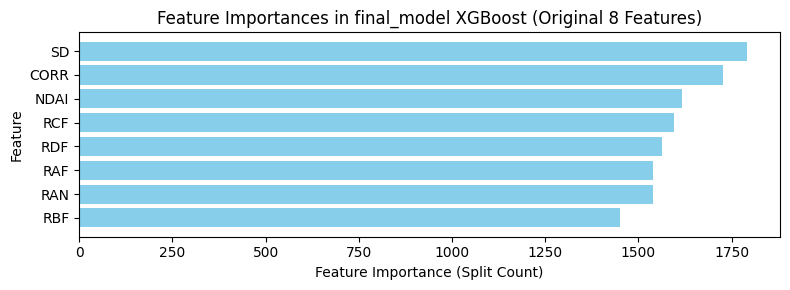

In [7]:
# Get feature importances from the XGBoost final_model
# we use "weight" as the importance type, which counts the number of splits using the feature.
importances_dict = final_model_1_xgboost.get_score(importance_type="weight")

if hasattr(X_test, "columns"):
    feature_names = list(X_test.columns)
else:
    feature_names = [f"f{i}" for i in range(X_test.shape[1])]

# Builds a list of (feature, importance) tuples.
feature_importance_pairs = []
for i, name in enumerate(feature_names):

    key = name if name in importances_dict else f"f{i}"
    importance_value = importances_dict.get(key, 0)
    feature_importance_pairs.append((name, importance_value))

# Sort features by importance (where highest is first)
feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

#all features and their importance
print("Feature Importances for final_model (Original 8 Features):")
for name, imp in feature_importance_pairs:
    print(f"{name}: {imp}")

#feature importances as a bar plot
features = [pair[0] for pair in feature_importance_pairs]
importances = [pair[1] for pair in feature_importance_pairs]

plt.figure(figsize=(8, 3))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Feature Importances in final_model XGBoost (Original 8 Features)')
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()


### Extra features

In [8]:
# Load the three csv files from data_labeled
image_1 = pd.read_csv('../data/data_labeled/image1_ae.csv') 
image_2 = pd.read_csv('../data/data_labeled/image2_ae.csv')
image_3 = pd.read_csv('../data/data_labeled/image3_ae.csv')

In [9]:

#Rename the first two columns!!! convert from x,y to X,Y
image_1 = image_1.rename(columns={'y': 'Y', 'x': 'X'})
image_2 = image_2.rename(columns={'y': 'Y', 'x': 'X'})
image_3 = image_3.rename(columns={'y': 'Y', 'x': 'X'})

# Merge original feature with 32 additional features on X and Y coordinates
df1_new = pd.merge(df1, image_1, on=['X', 'Y'], how='inner')
df2_new = pd.merge(df2, image_2, on=['X', 'Y'], how='inner')
df3_new = pd.merge(df3, image_3, on=['X', 'Y'], how='inner')
#now each df has 43 columns. (8 original + 32 new ae features) 

In [10]:

# Prepare features and labels
X_df1 = df1_new.drop(columns=['X', 'Y', 'label'])  # 40 features
y_df1 = df1_new['label']
X_df2 = df2_new.drop(columns=['X', 'Y', 'label'])
y_df2 = df2_new['label']
X_test = df3_new.drop(columns=['X', 'Y', 'label'])
y_test = df3_new['label']

df_train = pd.concat([df1_new, df2_new])
X_train_full = df_train.drop(columns=['X', 'Y', 'label'])
y_train_full = df_train['label']

In [21]:
# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [4, 5, 6],          # Allowing deeper trees to capture more complex interactions
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'min_child_weight': [1, 3]
}

# Base parameters for XGBoost
base_params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'error',          # Error = 1 - accuracy
    'colsample_bytree': 0.7,         # 
    'subsample': 0.8,                # 
    'verbosity': 0                   # Silence XGBoost output
}

###### 2-Fold CV setup #######
folds = [
    (X_df1, y_df1, X_df2, y_df2),  # Train on df1, validate on df2
    (X_df2, y_df2, X_df1, y_df1)   # Train on df2, validate on df1
]

# Hyperparameter tuning: grid search over the parameter combinations
best_params = None
best_avg_val_error = float('inf')

for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        params = base_params.copy()
        params['max_depth'] = max_depth
        params['learning_rate'] = learning_rate
        
        val_errors = []
        print(f"Testing: max_depth={max_depth}, learning_rate={learning_rate}")
        
        for X_train, y_train, X_valid, y_valid in folds:
            # Convert labels: -1 becomes 0, 1 stays 1
            y_train_mod = np.where(np.array(y_train) == -1, 0, y_train)
            y_valid_mod = np.where(np.array(y_valid) == -1, 0, y_valid)
            
            dtrain = xgb.DMatrix(X_train, label=y_train_mod)
            dvalid = xgb.DMatrix(X_valid, label=y_valid_mod)
            evals_result = {}
            
            model = xgb.train(
                params,
                dtrain,
                num_boost_round=500,
                evals=[(dvalid, 'valid')],
                early_stopping_rounds=20,
                evals_result=evals_result,
                verbose_eval=False
            )
            
            # Retrieve the best validation error from this fold
            best_iter = model.best_iteration
            fold_val_error = evals_result['valid']['error'][best_iter]
            val_errors.append(fold_val_error)
        
        avg_val_error = np.mean(val_errors)
        print(f"Average Validation Error: {avg_val_error:.4f}")
        
        if avg_val_error < best_avg_val_error:
            best_avg_val_error = avg_val_error
            best_params = params

print(f"\nBest Parameters: max_depth={best_params['max_depth']}, learning_rate={best_params['learning_rate']}")
print(f"Best Average Validation Error: {best_avg_val_error:.4f}")

# Retrain with best parameters on the full training data
y_train_full_mod = np.where(np.array(y_train_full) == -1, 0, y_train_full)
print("\nRetraining with best parameters...")
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full_mod)
final_model_2_xgboost = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=500  # Fixed rounds - no early stopping here
)

# Test on df3 (the third picture)
dtest = xgb.DMatrix(X_test)
y_pred_prob_2 = final_model_2_xgboost.predict(dtest)
y_pred_binary_2 = np.where(y_pred_prob_2 > 0.5, 1, -1)

test_accuracy_2 = accuracy_score(y_test, y_pred_binary_2)
test_error_2 = 1 - test_accuracy_2
print(f"Test Error with all features on df3: {test_error_2:.4f}")
print(f"Test Accuracy with all features on df3: {test_accuracy_2:.4f}")


Testing: max_depth=4, learning_rate=0.01
Average Validation Error: 0.1394
Testing: max_depth=4, learning_rate=0.05
Average Validation Error: 0.1367
Testing: max_depth=4, learning_rate=0.1
Average Validation Error: 0.1339
Testing: max_depth=4, learning_rate=0.15
Average Validation Error: 0.1355
Testing: max_depth=5, learning_rate=0.01
Average Validation Error: 0.1422
Testing: max_depth=5, learning_rate=0.05
Average Validation Error: 0.1369
Testing: max_depth=5, learning_rate=0.1
Average Validation Error: 0.1378
Testing: max_depth=5, learning_rate=0.15
Average Validation Error: 0.1390
Testing: max_depth=6, learning_rate=0.01
Average Validation Error: 0.1437
Testing: max_depth=6, learning_rate=0.05
Average Validation Error: 0.1444
Testing: max_depth=6, learning_rate=0.1
Average Validation Error: 0.1412
Testing: max_depth=6, learning_rate=0.15
Average Validation Error: 0.1396

Best Parameters: max_depth=4, learning_rate=0.1
Best Average Validation Error: 0.1339

Retraining with best parame

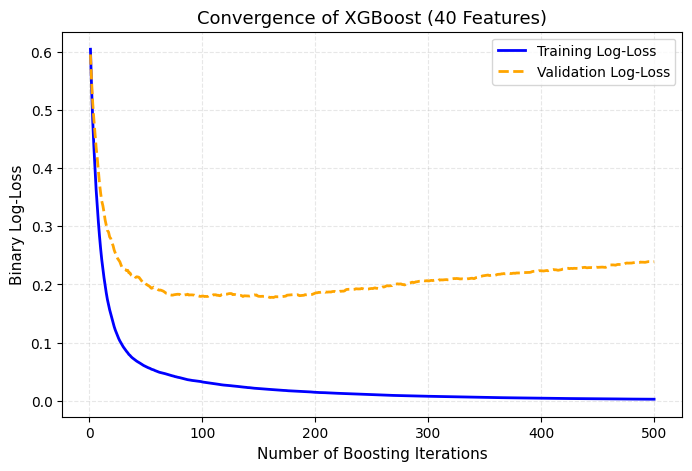

In [37]:
# tracking the binary log-loss over the number of boosting iterations

# Convert labels: -1 becomes 0, 1 stays 1 (as in your original code)
y_train_full_mod = np.where(np.array(y_train_full) == -1, 0, y_train_full)
y_test_mod = np.where(np.array(y_test) == -1, 0, y_test)

# Create DMatrix for training and validation
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full_mod)
dtest = xgb.DMatrix(X_test, label=y_test_mod)

# Define parameters with the best values
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Changed to logloss for convergence plot
    'max_depth': 4,  # Best parameter
    'learning_rate': 0.1,  # Best parameter
    'min_child_weight': 1,  # From your param_grid, assuming default
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'verbosity': 0
}

# Train the model with evaluation logging
evals_result = {}
final_model_2_xgboost = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=500,
    evals=[(dtrain_full, 'train'), (dtest, 'valid')],
    evals_result=evals_result,
    verbose_eval=False
)

# Extract log-loss values
train_logloss = evals_result['train']['logloss']
valid_logloss = evals_result['valid']['logloss']
iterations = range(1, len(train_logloss) + 1)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Training Log-Loss
plt.plot(iterations, train_logloss, label='Training Log-Loss', 
         color='blue', linewidth=2)

# Plot Validation Log-Loss with a dashed line
plt.plot(iterations, valid_logloss, label='Validation Log-Loss', 
         color='orange', linewidth=2, linestyle='dashed')

# Labels and Title
plt.xlabel('Number of Boosting Iterations', fontsize=11)
plt.ylabel('Binary Log-Loss', fontsize=11)
plt.title('Convergence of XGBoost (40 Features)', fontsize=13)

# Legend: Move outside for better readability
plt.legend(loc='upper right', fontsize=10, frameon=True)

# Subtle Grid
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('../figs/xgb_convergence.png', bbox_inches='tight')
# Show the plot
plt.show()

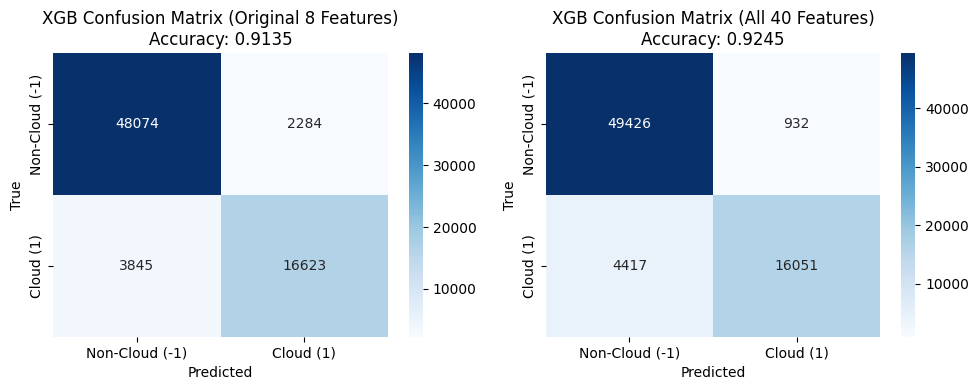

In [33]:
# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_binary_1)
cm_2 = confusion_matrix(y_test, y_pred_binary_2)

# Compute accuracies (for reference)
acc_1 = accuracy_score(y_test, y_pred_binary_1)
acc_2 = accuracy_score(y_test, y_pred_binary_2)

# Plot confusion matrices side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Original features
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
ax1.set_title(f'XGB Confusion Matrix (Original 8 Features)\nAccuracy: {acc_1:.4f}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# All features
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Non-Cloud (-1)', 'Cloud (1)'],
            yticklabels=['Non-Cloud (-1)', 'Cloud (1)'])
ax2.set_title(f'XGB Confusion Matrix (All 40 Features)\nAccuracy: {acc_2:.4f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.savefig('../figs/Xgboost_cm.png', bbox_inches='tight')
plt.show()

In [13]:
## Precision, Recall, F1 Score
# Compute for both models (for the positive class: Cloud, label=1)
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(y_test, y_pred_binary_1, average='binary', pos_label=1)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(y_test, y_pred_binary_2, average='binary', pos_label=1)

print("Model 1 (final_model_1_xgboost):")
print(f"Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1 Score: {f1_1:.4f}")
print("Model 2 (final_model_2_xgboost):")
print(f"Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_2:.4f}")

Model 1 (final_model_1_xgboost):
Precision: 0.8792, Recall: 0.8121, F1 Score: 0.8443
Model 2 (final_model_2_xgboost):
Precision: 0.9451, Recall: 0.7842, F1 Score: 0.8572


In [14]:

## Approximate AIC
# Number of features
k_1 = 8   # final_model_1_xgboost (original 8 features)
k_2 = 40  # final_model_2_xgboost (8 original + 32 autoencoded)

# Compute log-loss (requires prob. predictions)
logloss_1 = log_loss(y_test, y_pred_prob_1, labels=[-1, 1])
logloss_2 = log_loss(y_test, y_pred_prob_2, labels=[-1, 1])

# Approximate AIC: 2k + n * logloss (since logloss = -ln(L)/n, so -ln(L) = n * logloss)
n = len(y_test)
aic_1 = 2 * k_1 + n * logloss_1
aic_2 = 2 * k_2 + n * logloss_2

print("\nApproximate AIC:")
print(f"Model 1 (final_model_1_xgboost): {aic_1:.2f}")
print(f"Model 2 (final_model_2_xgboost): {aic_2:.2f}")


Approximate AIC:
Model 1 (final_model_1_xgboost): 16386.47
Model 2 (final_model_2_xgboost): 17022.83


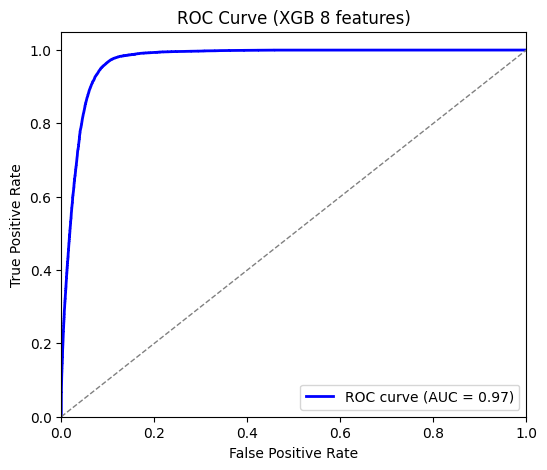

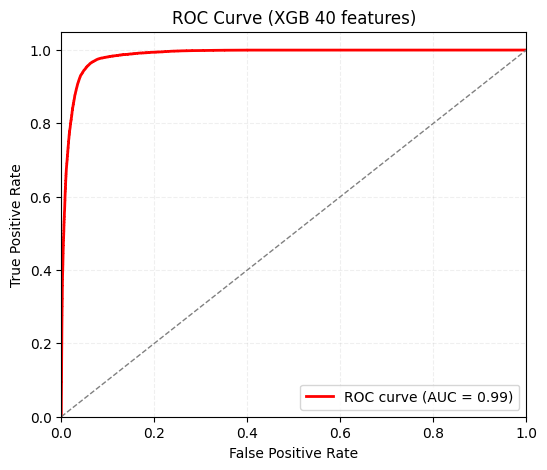

In [31]:
## ROC Curve
# Compute ROC curves and AUC
fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob_1, pos_label=1)
roc_auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, y_pred_prob_2, pos_label=1)
roc_auc_2 = auc(fpr_2, tpr_2)

# Model 1 ROC Curve (XGB 8 features)
plt.figure(figsize=(6, 5))  # Individual figure for Model 1
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGB 8 features)')
plt.legend(loc="lower right")
plt.show()

# Model 2 ROC Curve (XGB 40 features)
plt.figure(figsize=(6, 5))  # Individual figure for Model 2
plt.plot(fpr_2, tpr_2, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGB 40 features)')  # Fixed typo: "featrues" to "features"
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.2)
plt.savefig('../figs/xgb_roc_all.png', bbox_inches='tight')
plt.show()

Top 20 Most Important Features:
ae27: 389.0
ae7: 347.0
ae20: 272.0
SD: 249.0
ae0: 249.0
ae21: 244.0
ae11: 236.0
ae3: 223.0
ae29: 221.0
ae18: 198.0
ae6: 195.0
ae9: 193.0
ae23: 183.0
ae25: 178.0
ae28: 168.0
ae30: 166.0
ae4: 161.0
ae8: 161.0
ae22: 158.0
RAN: 157.0


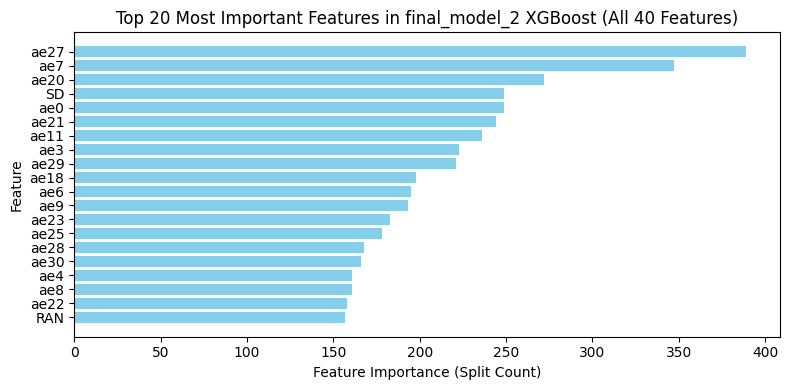

In [38]:
# feature importances from XGBoost final_model_2_xgboost using "weight" (split count)
importances_dict = final_model_2_xgboost.get_score(importance_type="weight")

# this is just a check to see if the feature names are available
if hasattr(X_test, "columns"):
    feature_names = list(X_test.columns)
else:
    feature_names = [f"f{i}" for i in range(X_test.shape[1])]

# Build a list of (feature, importance) tuples by matching keys
feature_importance_pairs = []
for i, name in enumerate(feature_names):
    key = name if name in importances_dict else f"f{i}"
    importance_value = importances_dict.get(key, 0)
    feature_importance_pairs.append((name, importance_value))

# Sort by importance in descending order
feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print top 20 features
print("Top 20 Most Important Features:")
for name, imp in feature_importance_pairs[:20]:
    print(f"{name}: {imp}")

# Plot top 20 features
top_20_features = [pair[0] for pair in feature_importance_pairs[:20]]
top_20_importances = [pair[1] for pair in feature_importance_pairs[:20]]

plt.figure(figsize=(8, 4))
plt.barh(top_20_features, top_20_importances, color='skyblue')
plt.xlabel('Feature Importance (Split Count)')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features in final_model_2 XGBoost (All 40 Features)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.savefig('../figs/xgb_features.png', bbox_inches='tight')
plt.show()


### Post-hoc EDA

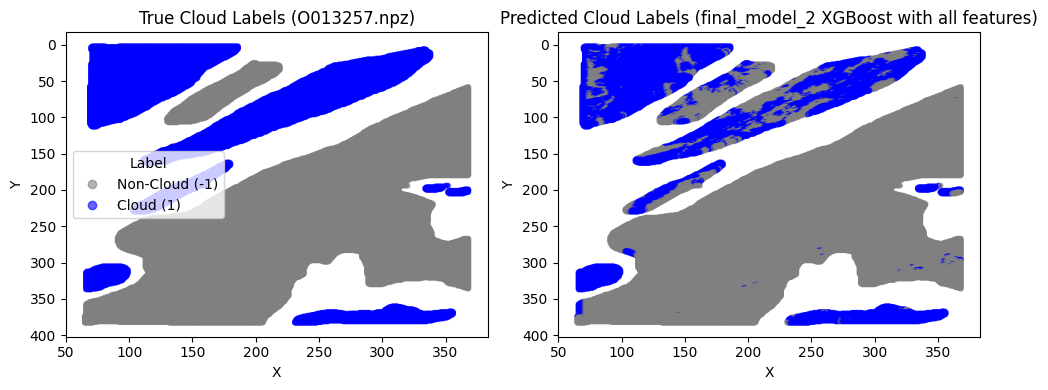

In [39]:
#plots for test picture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming df3_new and y_pred_binary_2 are already defined
# Create a dataframe with X, Y, true labels, and predicted labels
plot_df = pd.DataFrame({
    'X': df3_new['X'],
    'Y': df3_new['Y'],
    'True_Label': df3_new['label'],
    'Predicted_Label': y_pred_binary_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013257.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 XGBoost with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.savefig('../figs/postEDA_xgb_1.png', bbox_inches='tight')
plt.show()

In [18]:
# Convert the DataFrames to DMatrix objects
dX_df1 = xgb.DMatrix(X_df1)
dX_df2 = xgb.DMatrix(X_df2)

# Use final_model_2_xgboost to predict
y_pred_2_1 = final_model_2_xgboost.predict(dX_df1)
y_pred_2_2 = final_model_2_xgboost.predict(dX_df2)

# Get binary predictions based on a threshold of 0.5
y_pred_binary_2_1 = np.where(y_pred_2_1 > 0.5, 1, -1)
y_pred_binary_2_2 = np.where(y_pred_2_2 > 0.5, 1, -1)


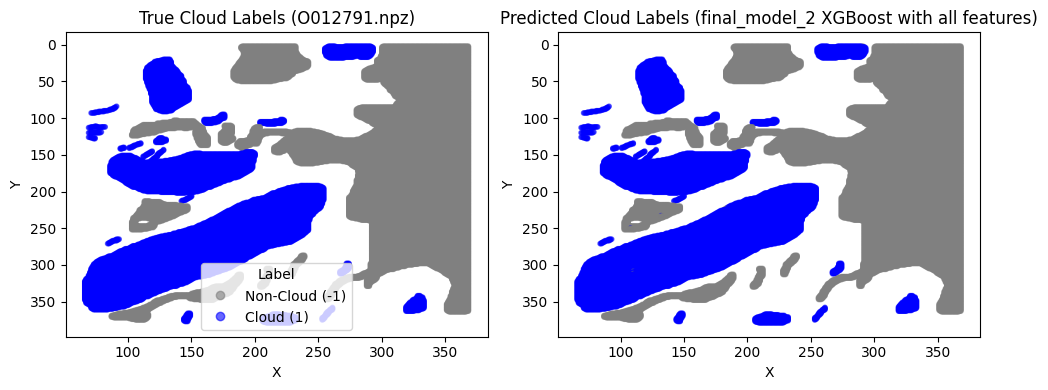

In [19]:
plot_df = pd.DataFrame({
    'X': df1_new['X'],
    'Y': df1_new['Y'],
    'True_Label': df1_new['label'],
    'Predicted_Label': y_pred_binary_2_1
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O012791.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 XGBoost with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()

handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()

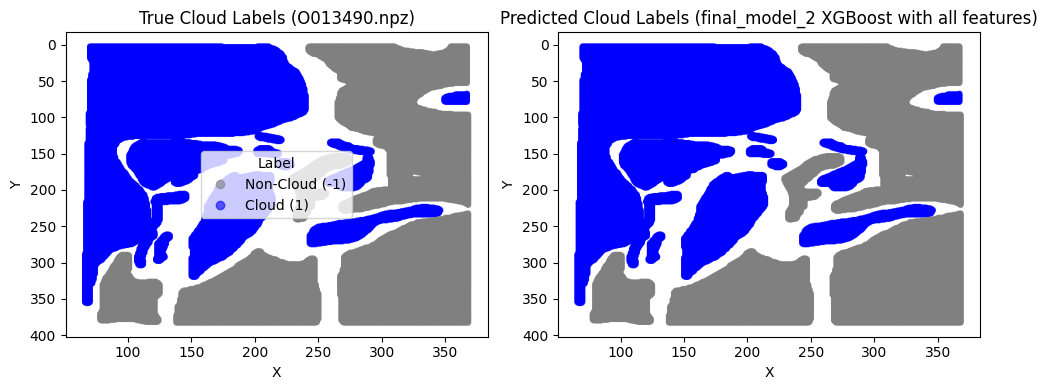

In [20]:
plot_df = pd.DataFrame({
    'X': df2_new['X'],
    'Y': df2_new['Y'],
    'True_Label': df2_new['label'],
    'Predicted_Label': y_pred_binary_2_2
})

# Define custom colormap: Non-Cloud (-1) -> grey, Cloud (1) -> blue
custom_cmap = ListedColormap(['grey', 'blue'])  # -1 (low) to 1 (high)

# Scatter Plots (True vs. Predicted)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# True Labels
scatter1 = ax1.scatter(plot_df['X'], plot_df['Y'], c=plot_df['True_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax1.set_title('True Cloud Labels (O013490.npz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()
# Legend
handles1, labels1 = scatter1.legend_elements()
ax1.legend(handles=handles1, labels=['Non-Cloud (-1)', 'Cloud (1)'], title="Label")

# Predicted Labels
scatter2 = ax2.scatter(plot_df['X'], plot_df['Y'], c=plot_df['Predicted_Label'], cmap=custom_cmap, s=10, alpha=0.6)
ax2.set_title('Predicted Cloud Labels (final_model_2 XGBoost with all features)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()
# Legend
handles2, labels2 = scatter2.legend_elements()

plt.tight_layout()
plt.show()